## Exploiting linearity

Model function is linear both in increasing $K$ *and* $N_P$.
We can exploit this using "nested model" inference.

Note: model can take very high $N_P$ in principle, but then $R$ becomes very sparse and we would need to take advantage of that for reasonable runtimes.
For example conjugate gradient (with preconditioning using a nearby live point) or block diagonal approximations.

## Amplitude priors

Trajectory on $f$ and $g$ ampltiudes: we use an envelope kernel with noise $\delta = 1$ because the parameters of source and filter envelope kernels (from period and reference formants, resp.) have been fitted in the *log* domain, so definitely their noise is unusable (since it is relative error, not absolute error), and their lengthscale correlations might be questioned, too. Ideally we would just fit new envelope trajectory kernels for $f$ and $g$ amplitudes to data, but this takes a lot of time. Or we could introduce their parameters into the inference to infer them dynamically, but this requires recalculating the bijectors at every step, and we have tried to avoid this. So we just stick with this strategy of keeping the lengthscale and the kernel, but setting the noise (nugget) to O(1) = 1. 

## Imputation

We can easily do data imputation with our work and see how well we predict.

## Residuals

Display residuals next to white noise -- gimmick

In [1]:
%run init.ipy

from lib import constants
from lib import klatt
from lib import util

## Get some test data from VTRFormants ***TEST*** set

In [2]:
import random
from vtr.prior import formant
from lib import timit

def rand_triple():
    vtr_root = timit.test_set(timit.VTRFORMANTS)
    timit_root = timit.test_set(timit.TIMIT)
    l = list(timit.yield_file_triples(vtr_root, timit_root))
    return random.choice(l)

fb_file, phn_file, wav_file = rand_triple()

2023-01-06 10:59:04.401506: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-06 10:59:04.401557: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-06 10:59:04.401561: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Test noise sigma prior

Test the noise sigma prior (bijector). We put a mean at -20 dB and floor it at the noise floor. Relative uncertainty is 100% leading to a nois power dB of roughly -20 +/- 7.5 dB.

(-21.104568398808986, 7.505976784200426)

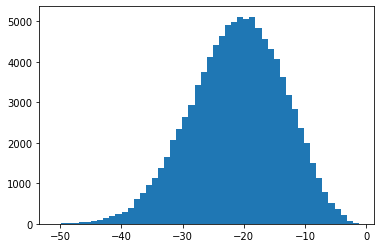

In [3]:
from inv import model

b = model.noise_sigma_bijector()

noise_sigmas = b.forward(randn(100000))

noise_power_dbs = 20*np.log10(noise_sigmas)

hist(noise_power_dbs, bins=50);

np.mean(noise_power_dbs), np.std(noise_power_dbs)

## Test model with random hyper priors

[Memory]31.0s, 0.5min   : Loading get_aplawd_training_pairs_subset...
[Memory]62.3s, 1.0min   : Loading run_nested...
[Memory]63.7s, 1.1min   : Loading run_nested...
[Memory]65.1s, 1.1min   : Loading run_nested...
[Memory]66.4s, 1.1min   : Loading run_nested...
NP = 5
Number of data points: 360
Number of model dimensions: 57


({'kernel_name': 'Matern32Kernel',
  'kernel_M': 64,
  'use_oq': True,
  'impose_null_integral': True},
 AllPoleFilter(3))

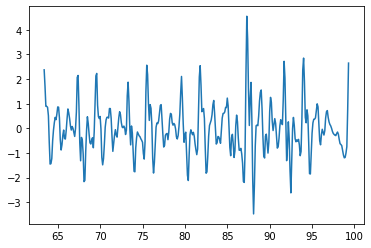

In [4]:
from inv import process
from vtr.prior import filter
import jax

source_config = dict(
    kernel_name = "Matern32Kernel",
    kernel_M = 64,
    use_oq = True,
    impose_null_integral = True
)

vtfilter = filter.AP(3, numpy_backend=jax.numpy, scipy_backend=jax.scipy)

hyper = process.make_rand_hyper(
    (fb_file, phn_file, wav_file),
    source_config = source_config,
    vtfilter = vtfilter,
    process_data_kwargs=dict(max_NP = 5, prepend=1)
)

plot(hyper['data']['t'], hyper['data']['d'])
print("NP =", hyper['data']['NP'])
print("Number of data points:", len(hyper['data']['d']))
print("Number of model dimensions:", model.ndim(hyper))

display(klatt.play(hyper['data']['t'], hyper['data']['d']))

hyper['source'], hyper['filter']

In [5]:
prior = model.theta_trajectory_prior(hyper)
theta = prior.sample(seed=jaxkey())
theta, prior.log_prob(theta)

[Memory]68.6s, 1.1min   : Loading get_aplawd_training_pairs_subset...
[Memory]69.0s, 1.1min   : Loading posterior_of_fitted_lf_values...
[Memory]69.3s, 1.2min   : Loading run_nested...
[Memory]69.6s, 1.2min   : Loading get_aplawd_training_pairs_subset...
[Memory]76.5s, 1.3min   : Loading posterior_of_fitted_TFB_values...
[Memory]76.8s, 1.3min   : Loading run_nested...
[Memory]76.9s, 1.3min   : Loading get_vtrformants_training_data...
[Memory]94.5s, 1.6min   : Loading run_nested...
[Memory]95.3s, 1.6min   : Loading run_nested...
[Memory]96.1s, 1.6min   : Loading run_nested...
[Memory]96.9s, 1.6min   : Loading run_nested...
[Memory]97.0s, 1.6min   : Loading get_vtrformants_training_data...


({'noise_sigma': DeviceArray(0.09515668, dtype=float64),
  'delta': DeviceArray(-2.5346309, dtype=float64),
  'source': DeviceArray([[ 2.66836712,  0.20433248,  6.91086492,  0.44434213],
               [ 2.64481402,  0.21125916,  6.63560981,  0.49631441],
               [ 2.03029743,  0.15309057,  6.77654545,  0.54726891],
               [ 2.06803391,  0.15011134,  7.66034432,  0.54309572],
               [ 1.74856411,  0.08155061, 11.35812107,  0.4932275 ]],            dtype=float64),
  'filter': DeviceArray([[ 725.20063899, 1775.17562837, 2224.14961287,   76.61798447,
                 358.81088316,  165.13848134],
               [ 674.32075988, 1707.5661649 , 2156.14407081,   69.71794475,
                 293.21376175,  161.23690121],
               [ 633.00068061, 1629.65968356, 2083.76668038,   62.54047013,
                 240.22032913,  155.80702991],
               [ 589.86141084, 1535.30997641, 2001.79270282,   54.27051415,
                 181.77787669,  133.8437404 ],
       

Show the possible model functions $f(t;\theta)$ for a sampled $\theta$. We need to find a $\theta$ for which **most** -- not just a few -- of these samples are close to the data. **This is Bayesian regularization in action.**

We can see that the general amplitude magnitude is reasonable, although for larger $K$ for PZ and $N_P$ it may take more samples to hit O(1) range. This is because of interpitch-period correlations and the heavier tails of the energy distribution of the PZ model.

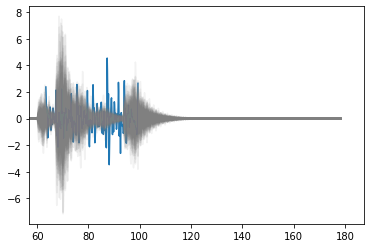

In [6]:
theta = prior.sample(seed=jaxkey())
noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)

hyper2 = process.hyper_fullt(hyper)

R = model.full_kernelmatrix_root(
    delta, theta_source, theta_filter, hyper2, convolve=True
)

plot(hyper['data']['t'], hyper['data']['d'])

nsamp = 100
for _ in range(nsamp):
    w = model.randf(hyper)
    f = R @ w
    plot(hyper['data']['fullt'], f, color='grey', alpha=1/sqrt(nsamp))

def setxlim(f, margin=0.05):
    ts = hyper['data']['fullt'][f != 0.]
    xlim(ts[0]*(1-margin), ts[-1]*(1+margin))

setxlim(f)

klatt.play(hyper['data']['t'], f)

We can see the correlations in the $f$ amplitudes well.

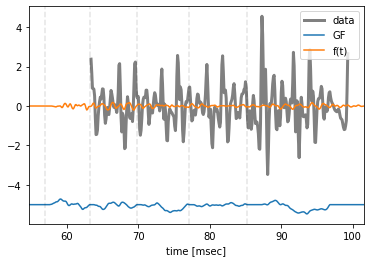

In [7]:
theta = prior.sample(seed=jaxkey())
noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)
offset = model.get_offset(delta, theta_source, hyper)

hyper2 = process.hyper_fullt(hyper)

R = model.full_kernelmatrix_root(
    delta, theta_source, theta_filter, hyper2, convolve=True, correlatef=False
)

R_gfd = model.full_kernelmatrix_root(
    delta, theta_source, theta_filter, hyper2, 
    convolve=False, integrate=True, correlatef=False
)

w = model.randf(hyper)

plot(hyper['data']['t'], hyper['data']['d'], color="grey", label="data", lw=3)

plot(hyper['data']['fullt'], R_gfd @ w - 5, label="GF")
plot(hyper['data']['fullt'], R @ w, label="f(t)")
for tp in offset: axvline(tp, ls="--", color="black", alpha=.1)
xlabel("time [msec]")
setxlim(R_gfd @ w)
legend();

## Test NS algorithm

In [8]:
import dynesty
import scipy
from inv import model

theta_bijector = model.theta_trajectory_bijector(hyper)
    
@jax.jit
def loglike(w):
    theta = theta_bijector.forward(w)
    logl = model.full_likelihood(theta, hyper)
    return logl

ptform = scipy.special.ndtri

ndim = model.ndim(hyper)
ndim

[Memory]119.2s, 2.0min  : Loading posterior_of_fitted_lf_values...
[Memory]119.2s, 2.0min  : Loading run_nested...
[Memory]119.2s, 2.0min  : Loading posterior_of_fitted_TFB_values...
[Memory]119.3s, 2.0min  : Loading run_nested...


57

In [9]:
w = ptform(rand(ndim))
loglike(w), theta_bijector.forward(w)

(DeviceArray(-917.82457213, dtype=float64),
 {'noise_sigma': DeviceArray(0.35491617, dtype=float64),
  'delta': DeviceArray(-0.41814998, dtype=float64),
  'source': DeviceArray([[ 3.14254348,  0.44790061,  6.22343944,  0.60671144],
               [ 2.58411635,  0.36598752,  7.23091743,  0.56399738],
               [ 2.12761605,  0.28793828,  7.75150098,  0.54675732],
               [ 1.71782606,  0.2226395 ,  8.31918555,  0.53374152],
               [ 1.94089013,  0.16019902, 12.27646863,  0.43828468]],            dtype=float64),
  'filter': DeviceArray([[ 830.38555323, 2089.18495381, 2725.68199413,   80.19595263,
                 343.00502472,  388.1574328 ],
               [ 798.04944109, 1991.67935971, 2613.01711721,   76.77352512,
                 288.36648384,  349.56020913],
               [ 747.57075561, 1881.94260866, 2480.18297352,   72.33960347,
                 238.47469313,  291.97187857],
               [ 684.77847415, 1784.29722163, 2356.64334888,   66.58244203,
         

In [10]:
SAMPLERARGS = {'sample': 'rslice', 'first_update': {'min_eff': 2.}}
RUNARGS = {'save_bounds': False, 'maxcall': int(1e7)}

sampler = dynesty.NestedSampler(
    loglike, ptform, ndim, nlive=ndim*3, **SAMPLERARGS
)

sampler.run_nested(**RUNARGS)
results = sampler.results

12836it [2:39:39,  1.34it/s, +171 | bound: 378 | nc: 1 | ncall: 4205612 | eff(%):  0.309 | loglstar:   -inf < -0.239 <    inf | logz: -73.436 +/-  0.595 | dlogz:  0.001 >  0.180]


Summary
nlive: 171
niter: 12836
ncall: 4205441
eff(%):  0.309
logz: -73.436 +/-  0.686


None

'Information (bans)'

23.60178737323075

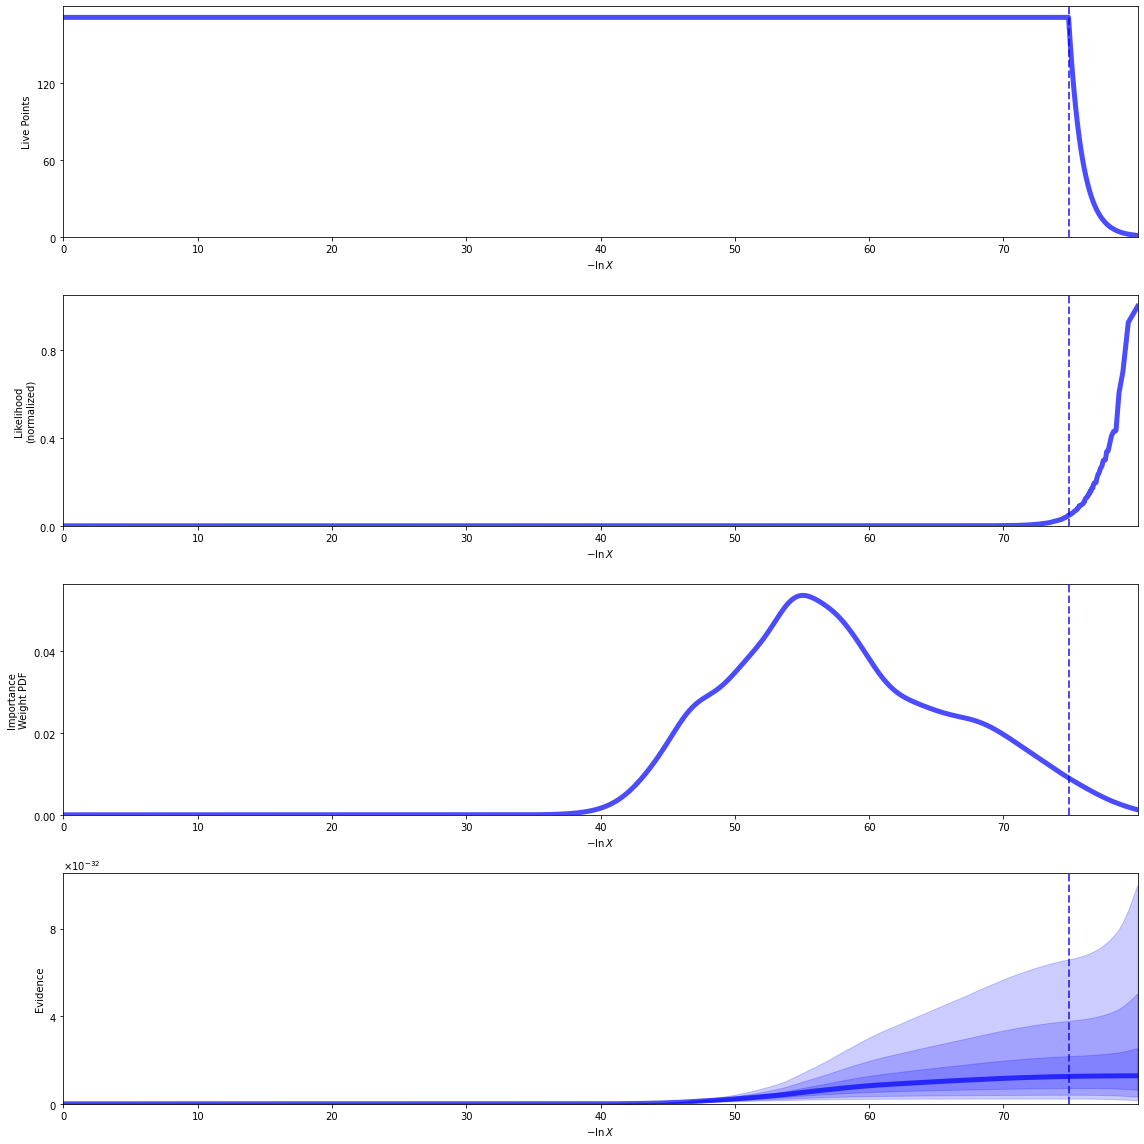

Quantiles:
$x_{1}$ [(0.025, 0.5475445114237785), (0.5, 0.7283868712551331), (0.975, 0.8667702878312498)]
Quantiles:
$x_{2}$ [(0.025, -1.775431497443819), (0.5, -1.5710681366741024), (0.975, -1.4545112033043848)]
Quantiles:
$x_{3}$ [(0.025, -1.6962342510512531), (0.5, -1.3600459838868197), (0.975, -1.0218816846896388)]
Quantiles:
$x_{4}$ [(0.025, -1.5220393992537602), (0.5, -0.050214419365817775), (0.975, 1.280334220397057)]
Quantiles:
$x_{5}$ [(0.025, -1.1126263296474599), (0.5, 0.10339496737119888), (0.975, 1.2428455000546348)]
Quantiles:
$x_{6}$ [(0.025, -2.2980818056335823), (0.5, -0.9251517987694059), (0.975, -0.009252230369161075)]
Quantiles:
$x_{7}$ [(0.025, -0.1837120727195133), (0.5, 1.0202845042580437), (0.975, 2.2837817555403785)]
Quantiles:
$x_{8}$ [(0.025, -3.80185006065049), (0.5, -3.089217681794301), (0.975, -2.1357030112946997)]
Quantiles:
$x_{9}$ [(0.025, -2.4793002772123005), (0.5, -1.0406000705750713), (0.975, 0.06694008353395575)]
Quantiles:
$x_{10}$ [(0.025, -1.5307

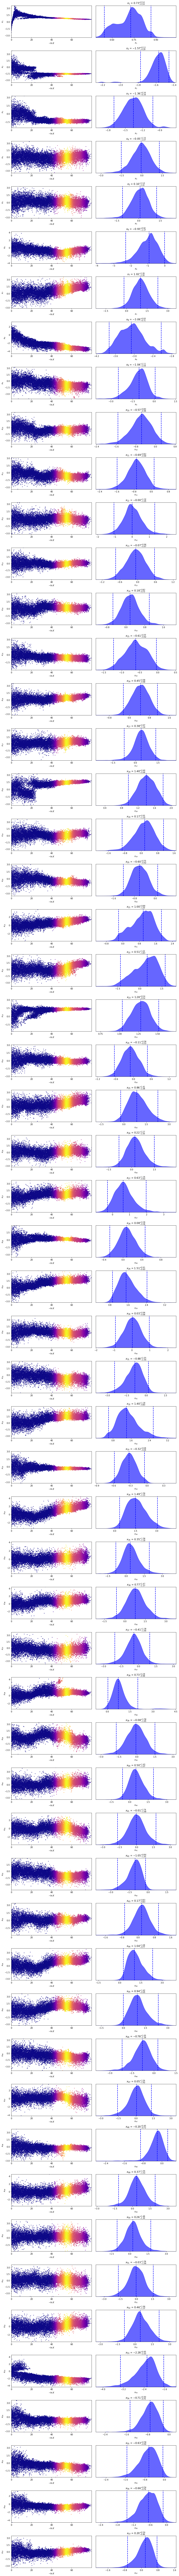

In [11]:
util.dyplot(results, cornerplot=False)

In [12]:
def lstsq(R, y, noise_power):
    D = jnp.eye(R.shape[1])
    Z = noise_power * D + R.T @ R
    L, lower = jax.scipy.linalg.cho_factor(Z, lower=True, check_finite=False)
    b = R.T @ y
    x = jax.scipy.linalg.cho_solve((L, lower), b, check_finite=False)
    return x

0	log L = -4.489667334915509	SNR [dB] = 16.50859424249675
1	log L = -20.242945759928205	SNR [dB] = 15.185806532220738
2	log L = -7.75475366989798	SNR [dB] = 16.527874849560167
3	log L = -17.921407559037704	SNR [dB] = 15.30445635613884
4	log L = -17.39220800000254	SNR [dB] = 15.443389238360457
5	log L = -9.041641322460208	SNR [dB] = 16.21312241368013
6	log L = -18.54792544472315	SNR [dB] = 15.31203954175962
7	log L = -23.315057947591413	SNR [dB] = 14.928197626780388
8	log L = -24.830988034605923	SNR [dB] = 14.64167814599282
9	log L = -8.240821578687758	SNR [dB] = 16.61474232142535


DeviceArray(-1.41885704, dtype=float64)

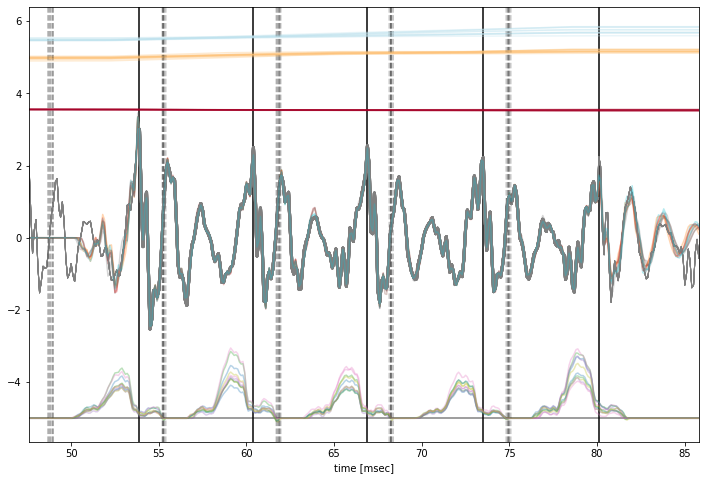

In [13]:
nsamp = 10

w_samples = util.resample_equal(results, nsamp)

figsize(12, 8)
axhline(-5, color="grey")

for pest in hyper['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, hyper), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)
    offset = model.get_offset(delta, theta_source, hyper)
    print("SNR [dB] =", -20*log10(noise_sigma))

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper, convolve=True
    )

    f_mean = lstsq(R, hyper['data']['d'], noise_sigma**2)

    hyper2 = process.hyper_fullt(hyper)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    
    alpha = 1/sqrt(nsamp)
    plot(hyper['data']['fullt'], hyper['data']['fulld'], color="grey", label="data", lw=1)
    plot(hyper['data']['t'], hyper['data']['d'], color="grey", label="data", lw=3)
    plot(hyper['data']['fullt'], gf - 5, label="GF", alpha=alpha)
    plot(hyper['data']['fullt'], ft, label="f(t)", alpha=alpha)
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            hyper['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            hyper['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/hyper['filter'].K)
        )

    #display(klatt.play(hyper['data']['t'], hyper['data']['d']))
    #display(klatt.play(hyper['data']['t'], ft))

delta

In [14]:
model.unpack_theta(theta, hyper)

(DeviceArray(0.14766001, dtype=float64),
 DeviceArray(-1.41885704, dtype=float64),
 {'Oq': DeviceArray([0.79794887, 0.80072741, 0.74551209, 0.80081757, 0.82043232],            dtype=float64),
  'T': DeviceArray([6.60961707, 6.55397566, 6.37383742, 6.8178524 , 6.7190611 ],            dtype=float64),
  'r': DeviceArray([0.0154298 , 0.01644819, 0.01515874, 0.01467505, 0.02024349],            dtype=float64),
  'var_sigma': DeviceArray([0.53169238, 0.63903568, 0.6039678 , 0.61448865, 0.90846768],            dtype=float64)},
 {'g': DeviceArray([[-3.99884353],
               [-2.40710116],
               [-3.20530617],
               [-2.81765919],
               [-1.73422192]], dtype=float64),
  'x': DeviceArray([[ 553.98549795, 1897.28638311, 2468.81740019],
               [ 539.95084657, 1983.51839656, 2530.78449046],
               [ 543.12921281, 2088.34327597, 2629.34846751],
               [ 538.78521868, 2133.6345758 , 2731.10125315],
               [ 536.44646513, 2211.01843949, 2844

## Without `Oq`

In [ ]:
hyper_woq = process.hyper_variation(hyper, use_oq=False)

In [ ]:
theta_bijector = model.theta_trajectory_bijector(hyper_woq)
    
@jax.jit
def loglike(w):
    theta = theta_bijector.forward(w)
    logl = model.full_likelihood(theta, hyper_woq)
    return logl

ptform = scipy.special.ndtri

ndim = model.ndim(hyper_woq)
ndim

In [ ]:
w = ptform(rand(ndim))
loglike(w), theta_bijector.forward(w)

In [ ]:
SAMPLERARGS = {'sample': 'rslice', 'first_update': {'min_eff': 2.}}
RUNARGS = {'save_bounds': False, 'maxcall': int(1e7)}

sampler = dynesty.NestedSampler(
    loglike, ptform, ndim, nlive=ndim*3, **SAMPLERARGS
)

sampler.run_nested(**RUNARGS)
results = sampler.results

In [ ]:
util.dyplot(results, cornerplot=False)

In [ ]:
nsamp = 10

w_samples = util.resample_equal(results, nsamp)

figsize(12, 8)
axhline(-5, color="grey")

for pest in hyper_woq['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, hyper_woq), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper_woq)
    offset = model.get_offset(delta, theta_source, hyper_woq)
    print("SNR [dB] =", -20*log10(noise_sigma))

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper_woq, convolve=True
    )

    f_mean = lstsq(R, hyper_woq['data']['d'], noise_sigma**2)

    hyper_woq2 = process.hyper_fullt(hyper_woq)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper_woq2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper_woq2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    
    alpha = 1/sqrt(nsamp)
    plot(hyper_woq['data']['fullt'], hyper_woq['data']['fulld'], color="grey", label="data", lw=1)
    plot(hyper_woq['data']['t'], hyper_woq['data']['d'], color="grey", label="data", lw=3)
    plot(hyper_woq['data']['fullt'], gf - 5, label="GF", alpha=alpha)
    plot(hyper_woq['data']['fullt'], ft, label="f(t)", alpha=alpha)
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            hyper_woq['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            hyper_woq['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/hyper_woq['filter'].K)
        )

delta

In [ ]:
model.unpack_theta(theta, hyper_woq)

## With OQ and PZ

In [ ]:
hyper_woq = process.hyper_variation(
    hyper, use_oq=True,
    filter=filter.PZ(3, numpy_backend=jax.numpy, scipy_backend=jax.scipy)
)

In [ ]:
theta_bijector = model.theta_trajectory_bijector(hyper_woq)
    
@jax.jit
def loglike(w):
    theta = theta_bijector.forward(w)
    logl = model.full_likelihood(theta, hyper_woq)
    return logl

ptform = scipy.special.ndtri

ndim = model.ndim(hyper_woq)
ndim

In [ ]:
w = ptform(rand(ndim))
loglike(w), theta_bijector.forward(w)

In [ ]:
SAMPLERARGS = {'sample': 'rslice', 'first_update': {'min_eff': 2.}}
RUNARGS = {'save_bounds': False, 'maxcall': int(1e7)}

sampler = dynesty.NestedSampler(
    loglike, ptform, ndim, nlive=ndim*3, **SAMPLERARGS
)

sampler.run_nested(**RUNARGS)
results = sampler.results

In [ ]:
util.dyplot(results, cornerplot=False)

In [ ]:
nsamp = 10

w_samples = util.resample_equal(results, nsamp)

figsize(12, 8)
axhline(-5, color="grey")

for pest in hyper_woq['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, hyper_woq), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper_woq)
    offset = model.get_offset(delta, theta_source, hyper_woq)
    print("SNR [dB] =", -20*log10(noise_sigma))

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper_woq, convolve=True
    )

    f_mean = lstsq(R, hyper_woq['data']['d'], noise_sigma**2)

    hyper_woq2 = process.hyper_fullt(hyper_woq)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper_woq2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper_woq2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    
    alpha = 1/sqrt(nsamp)
    plot(hyper_woq['data']['fullt'], hyper_woq['data']['fulld'], color="grey", label="data", lw=1)
    plot(hyper_woq['data']['t'], hyper_woq['data']['d'], color="grey", label="data", lw=3)
    plot(hyper_woq['data']['fullt'], gf - 5, label="GF", alpha=alpha)
    plot(hyper_woq['data']['fullt'], ft, label="f(t)", alpha=alpha)
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            hyper_woq['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            hyper_woq['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/hyper_woq['filter'].K)
        )

delta

In [ ]:
model.unpack_theta(theta, hyper_woq)

## Without OQ, with PZ

In [ ]:
hyper_woq = process.hyper_variation(
    hyper, use_oq=False,
    filter=filter.PZ(3, numpy_backend=jax.numpy, scipy_backend=jax.scipy)
)

In [ ]:
theta_bijector = model.theta_trajectory_bijector(hyper_woq)
    
@jax.jit
def loglike(w):
    theta = theta_bijector.forward(w)
    logl = model.full_likelihood(theta, hyper_woq)
    return logl

ptform = scipy.special.ndtri

ndim = model.ndim(hyper_woq)
ndim

In [ ]:
w = ptform(rand(ndim))
loglike(w), theta_bijector.forward(w)

In [ ]:
SAMPLERARGS = {'sample': 'rslice', 'first_update': {'min_eff': 2.}}
RUNARGS = {'save_bounds': False, 'maxcall': int(1e7)}

sampler = dynesty.NestedSampler(
    loglike, ptform, ndim, nlive=ndim*3, **SAMPLERARGS
)

sampler.run_nested(**RUNARGS)
results = sampler.results

In [ ]:
util.dyplot(results, cornerplot=False)

In [ ]:
nsamp = 10

w_samples = util.resample_equal(results, nsamp)

figsize(12, 8)
axhline(-5, color="grey")

for pest in hyper_woq['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, hyper_woq), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper_woq)
    offset = model.get_offset(delta, theta_source, hyper_woq)
    print("SNR [dB] =", -20*log10(noise_sigma))

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper_woq, convolve=True
    )

    f_mean = lstsq(R, hyper_woq['data']['d'], noise_sigma**2)

    hyper_woq2 = process.hyper_fullt(hyper_woq)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper_woq2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper_woq2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    
    alpha = 1/sqrt(nsamp)
    plot(hyper_woq['data']['fullt'], hyper_woq['data']['fulld'], color="grey", label="data", lw=1)
    plot(hyper_woq['data']['t'], hyper_woq['data']['d'], color="grey", label="data", lw=3)
    plot(hyper_woq['data']['fullt'], gf - 5, label="GF", alpha=alpha)
    plot(hyper_woq['data']['fullt'], ft, label="f(t)", alpha=alpha)
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            hyper_woq['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            hyper_woq['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/hyper_woq['filter'].K)
        )

delta

In [ ]:
model.unpack_theta(theta, hyper_woq)

## Test Hamiltonian NS

In [73]:
import dynesty
import scipy

theta_bijector_unit = model.theta_trajectory_bijector_unit_cube(hyper)

@jax.jit
def loglike(u):
    theta = theta_bijector_unit.forward(u)
    logl = model.full_likelihood(theta, hyper)
    return logl

ptform = lambda x: x

grad_u = jax.jit(jax.grad(loglike))

ndim = model.ndim(hyper)

[Memory]1669.0s, 27.8min: Loading posterior_of_fitted_lf_values...
[Memory]1669.0s, 27.8min: Loading run_nested...
[Memory]1669.0s, 27.8min: Loading posterior_of_fitted_TFB_values...
[Memory]1669.0s, 27.8min: Loading run_nested...


In [74]:
u = ptform(rand(ndim))
loglike(u)#, grad_u(u)

DeviceArray(-7791.70494648, dtype=float64)

In [75]:
grad_u(u)

2022-12-20 22:17:08.674817: E external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_compiler.cc:1369] The CUDA linking API did not work. Please use XLA_FLAGS=--xla_gpu_force_compilation_parallelism=1 to bypass it, but expect to get longer compilation time due to the lack of multi-threading.


XlaRuntimeError: UNKNOWN: device kernel image is invalid
in external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_asm_compiler.cc(68): 'cuLinkComplete(link_state, &cubin_out, &cubin_size)'

In [ ]:
SAMPLERARGS = {'sample': 'rslice', 'bootstrap': 50}
RUNARGS = {'save_bounds': False, 'maxcall': int(1e5)}

sampler = dynesty.NestedSampler(
    loglike, ptform, ndim, nlive=ndim*3, sample='hslice',
    gradient=grad_u, **SAMPLERARGS
)

sampler.run_nested(**RUNARGS)
results = sampler.results